# Get dataframe of "final" CMIP6 files

Parse the "final" directory on sitestore, and create a pandas dataframe with all internally published files,
and associated information, such as variable name, table, etc. This dataframe can then be parsed to answer
 questions such as "which experiments have published tas"? or "which years of piControl have published monthly tos"?

In [5]:
import os 
import fnmatch
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import intake
import cftime
from tqdm.autonotebook import tqdm
import seaborn as sns

## Parse the directories to get the dataframe

In [6]:
cat_url = "/space/hall4/sitestore/eccc/crd/CMIP6/final/canesm_final.json"
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [7]:
col.nunique()

activity_id            14
institution_id          1
source_id               2
experiment_id         101
member_id             126
table_id               25
variable_id           386
grid_label              1
dcpp_init_year         57
version                 2
time_range           1032
path              1125422
dtype: int64

In [8]:
df = col.df

In [9]:
df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'dcpp_init_year',
       'version', 'time_range', 'path'],
      dtype='object')

In [10]:
pd.options.display.max_rows = 999

In [11]:
last_day={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

def time_range_to_days(tr):
    '''Convert from time_range strings to days of simulation per file'''
    try:
        (start_date, end_date) = tr.split('-')
        if len(start_date)==6:
            syear = int(start_date[0:4])
            eyear = int(end_date[0:4])
            smon = int(start_date[4:6])
            emon = int(end_date[4:6])        
        elif len(start_date)==4:
            syear = int(start_date[0:4])
            eyear = int(end_date[0:4])
            smon = 1
            emon = 12                
        else:
            delta=0
            return delta
               
        delta=(cftime.DatetimeNoLeap(eyear, emon, last_day[emon]) - 
               cftime.DatetimeNoLeap(syear, smon,  1)).days
        
    except:
        delta=0            
        
    return delta

In [12]:
simdays = df['time_range'].apply(time_range_to_days)

In [13]:
df3= df
df3['simdays'] = simdays

In [14]:
df3['simdays'].sum()/365./1e5

300.9039296986301

/tmp/ncs001/37139/ipykernel_39341/1517604784.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpu" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cccma_cmip6_contribution.png', bbox_inches='tight', dpu=300)


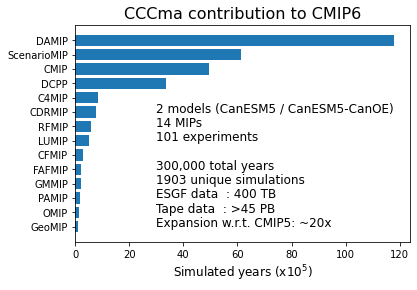

In [16]:
mip_real = df3.groupby(['activity_id', 
            'experiment_id']).agg({"simdays": "sum"}).groupby('activity_id').sum().sort_values(by='simdays')
y_pos = np.arange(len(mip_real))
plt.barh(y_pos, mip_real.squeeze().values/365/1e5, align='center')
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(mip_real.index)
plt.xlabel('Simulated years (x10$^5$)', fontsize=12)

plt.text(30,8, '2 models (CanESM5 / CanESM5-CanOE)', fontsize=12)
plt.text(30,7, '14 MIPs', fontsize=12)
plt.text(30,6, '101 experiments', fontsize=12)

plt.text(30,4, '300,000 total years', fontsize=12)
plt.text(30,3, '1903 unique simulations', fontsize=12)
plt.text(30,2, 'ESGF data  : 400 TB', fontsize=12)
plt.text(30,1, 'Tape data  : >45 PB', fontsize=12)
plt.text(30, 0,'Expansion w.r.t. CMIP5: ~20x', fontsize=12)

plt.title('CCCma contribution to CMIP6', fontsize=16)
plt.savefig('cccma_cmip6_contribution.png', bbox_inches='tight', dpu=300)

In [322]:
df['time_range'].dropna().str.split('-',n=1, expand=True)

0         1
0          185001    200012
1          185001    200012
2          185001    200012
3          185001    200012
4          185001    200012
...           ...       ...
1121193  20510101  20601231
1121194  20610101  20701231
1121195  20710101  20801231
1121196  20810101  20901231
1121197  20910101  21001231

[1101206 rows x 2 columns]

In [116]:
# Calculate the total number of years simulated

split_times = df['time_range'].dropna().str.split('-', n=1, expand=True)
#pd.to_datetime(split_times[0],format='%Y%m')

start_dates = split_times[0].values
end_dates = split_times[1].values

last_day={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

deltas = []
for i in tqdm(range(len(split_times))):
    if len(start_dates[i])==6:
        syear = int(start_dates[i][0:4])
        eyear = int(end_dates[i][0:4])
        smon = int(start_dates[i][4:6])
        emon = int(end_dates[i][4:6])        
    elif len(start_dates[i])==4:
        syear = int(start_dates[i][0:4])
        eyear = int(end_dates[i][0:4])
        smon = 1
        emon = 12                
    else:
        deltas.append(np.nan)
        continue    
        
    deltas.append(cftime.DatetimeNoLeap(eyear, emon, last_day[emon]) - 
                  cftime.DatetimeNoLeap(syear, smon,  1))

In [139]:
a=pd.Series(np.array(deltas)).dropna()

In [141]:
tot = 0 
for d in a:
    tot = tot + d.days

In [143]:
tot/365./1e5

300.70150320547947

### What is the list of MIPs contributed to so far?

In [18]:
', '.join(list(set(df.activity_id)))

'C4MIP, ScenarioMIP, RFMIP, GMMIP, DCPP, LUMIP, PAMIP, FAFMIP, CMIP, CDRMIP, CFMIP, OMIP, GeoMIP, DAMIP'

In [22]:
num_mips = len(set(df.activity_id))
print(f'Number of MIPs contributed to: {num_mips}')

Number of MIPs contributed to: 14


### What is the list of experiments published so far?

In [17]:
', '.join(list(set(df.experiment_id)))

'amip-p4K, pdSST-pdSIC, ssp245-GHG, omip1-spunup, amip-hist, amip-4xCO2, esm-pi-cdr-pulse, ssp245-aer, esm-1pct-brch-2000PgC, abrupt-0p5xCO2, rcp26-cmip5, amip-m4K, piControl-cmip5, futSST-pdSIC, historical-cmip5, hist-sol, pdSST-futArcSIC, faf-passiveheat, rad-irf, amip-future4K, hist-nat, piClim-histaer, 1pctCO2-bgc, deforest-globe, hist-volc, hist-GHG, abrupt-2xCO2, abrupt-solm4p, faf-water, piClim-4xCO2, ssp245-nat, esm-ssp585, 1pctCO2-cdr, pdSST-futBKSeasSIC, piSST-pdSIC, esm-hist, dcppA-hindcast, pdSST-piAntSIC, 1pctCO2-rad, ssp119, rcp85-cmip5, pdSST-piArcSIC, faf-heat-NA0pct, esm-1pct-brch-1000PgC, pdSST-futOkhotskSIC, pdSST-futAntSIC, ssp585-bgc, historical, hist-GHG-cmip5, ssp585, dcppC-forecast-addAgung, dcppC-hindcast-noPinatubo, amip, esm-ssp585-ssp126Lu, G1, hist-noLu, rcp45-cmip5, ssp460, ssp126-ssp370Lu, hist-stratO3, piClim-control, 1pctCO2, ssp370, esm-piControl, dcppC-forecast-addElChichon, ssp245-stratO3, ssp370-ssp126Lu, ssp534-over, piSST-piSIC, ssp434, faf-stress

In [14]:
num_exps = len(set(df.experiment_id))
print(f'Number of experiments published: {num_exps}')

Number of experiments published 101


### What is the numer of unique realizations/simulations published so far?

In [168]:
num_rels = df.groupby(['activity_id', 'experiment_id']).agg({"member_id": "nunique"}).sum()
print(f'Number of experiments published: {num_rels}')

Number of experiments published: member_id    1903
dtype: int64


### What is the list of variables published to so far?

In [20]:
', '.join(list(set(df.variable_id)))

'jpdftaureicemodis, emidms, od550csaer, zmicroos, cropFracC4, rlut4co2, ua, fgcfc11, mlotstmax, clivi, dissicabioos, cltisccp, calc, co3, tas, zg100, ps, siu, cfc11, treeFracNdlEvg, cLand, siconca, dfe, wap, no3, rsutcs4co2, spco2, nh4os, chl, dfeos, cldnvi, cdnc, pathetao, sob, tauu, vtem, cropFrac, rsutcs, grassFracC4, so, sftof, tauv, rsutcsaf, abs550aer, bldep, rsdsdiff, mrlso, co3satcalcos, pp, phyn, phyfeos, nppLeaf, ponos, nbp, sftgif, hursmin, cltmodis, albisccp, fgo2, emibc, hfls, grassFracC3, osalttend, wetso2, sispeed, ra, wetbc, ci, sftlf, ta850, opottempdiff, co3sataragos, sisnthick, ppdiat, prveg, pctisccp, clcalipsoliq, ccb, cltcalipso, nh4, treeFrac, fgco2, intppdiat, sisnmass, uo, cls, siconc, prc, tasmin, sitimefrac, treeFracBdlDcd, rsdo, clmisr, limndiat, clmcalipso, rsut, co3satarag, difvho, rsu, utendwtem, phnatos, o2os, chlmiscos, evspsblveg, epc100, dryso2, vtendogw, wo, opottemppmdiff, dissicos, zg, cStem, huss, tosga, spco2abio, friver, vmo, wetlandCH4prod, npp

In [23]:
num_vars = len(set(df.variable_id))
print(f'Number of variables published so far: {num_vars}')

Number of variables published so far: 386


[Text(0, 0, 'C4MIP'),
 Text(0, 0, 'CDRMIP'),
 Text(0, 0, 'CFMIP'),
 Text(0, 0, 'CMIP'),
 Text(0, 0, 'DAMIP'),
 Text(0, 0, 'DCPP'),
 Text(0, 0, 'FAFMIP'),
 Text(0, 0, 'GMMIP'),
 Text(0, 0, 'GeoMIP'),
 Text(0, 0, 'LUMIP'),
 Text(0, 0, 'OMIP'),
 Text(0, 0, 'PAMIP'),
 Text(0, 0, 'RFMIP'),
 Text(0, 0, 'ScenarioMIP')]

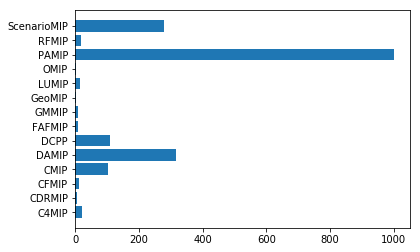

In [252]:
mip_real = df.groupby(['activity_id', 
            'experiment_id']).agg({"member_id": "nunique"}).groupby('activity_id').sum()
y_pos = np.arange(len(mip_real))
plt.barh(y_pos, mip_real.squeeze(), align='center')
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(mip_real.index)

Text(0.5, 1.0, 'Number of variables finalized')

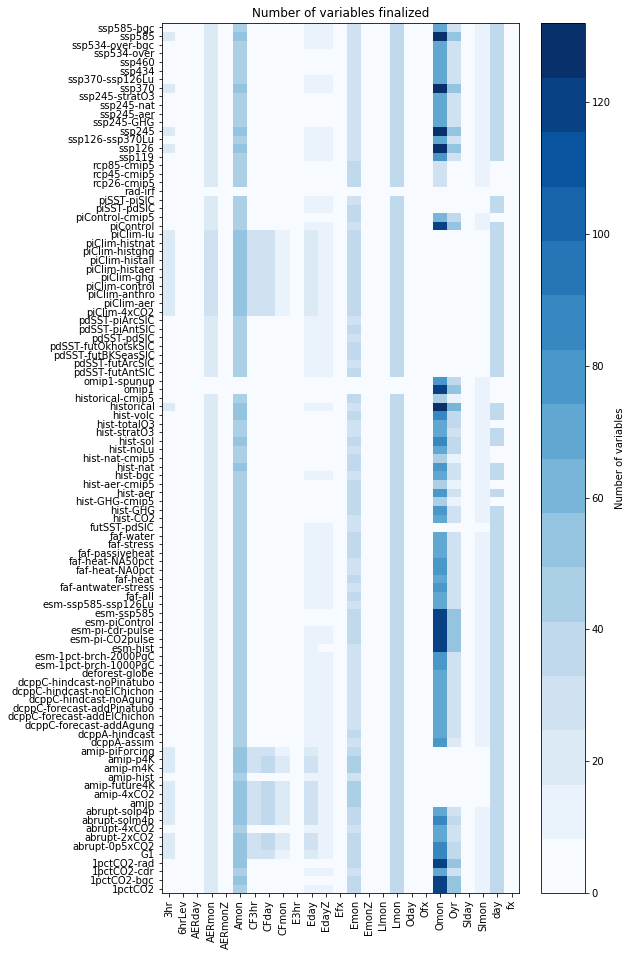

In [264]:
a = df.groupby(['table_id', 'experiment_id'])['variable_id'].nunique().unstack().T #.pivot(index='experiment', columns='table', values='variable')
fig, ax = plt.subplots(1,1,figsize=(8,16))
nc=16
blues = plt.cm.get_cmap('Blues', 16)
#blues.set_under('0.75')
#bounds=[0] + range(1,int(a.max().max()), int(a.max().max()/nc))
#norm = mpl.colors.BoundaryNorm(bounds, blues.N)
cob=ax.pcolormesh(a.fillna(0).values, cmap=blues)
ax.set_xticks(np.arange(len(a.columns))+0.5)
ax.set_xticklabels(a.columns, rotation=90)
ax.set_yticks(np.arange(len(a))+0.5)
ax.set_yticklabels(a.index)
#ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
#ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(True, which='minor')
plt.colorbar(cob, label='Number of variables')#, norm=norm, boundaries=bounds)
ax.set_title('Number of variables finalized')

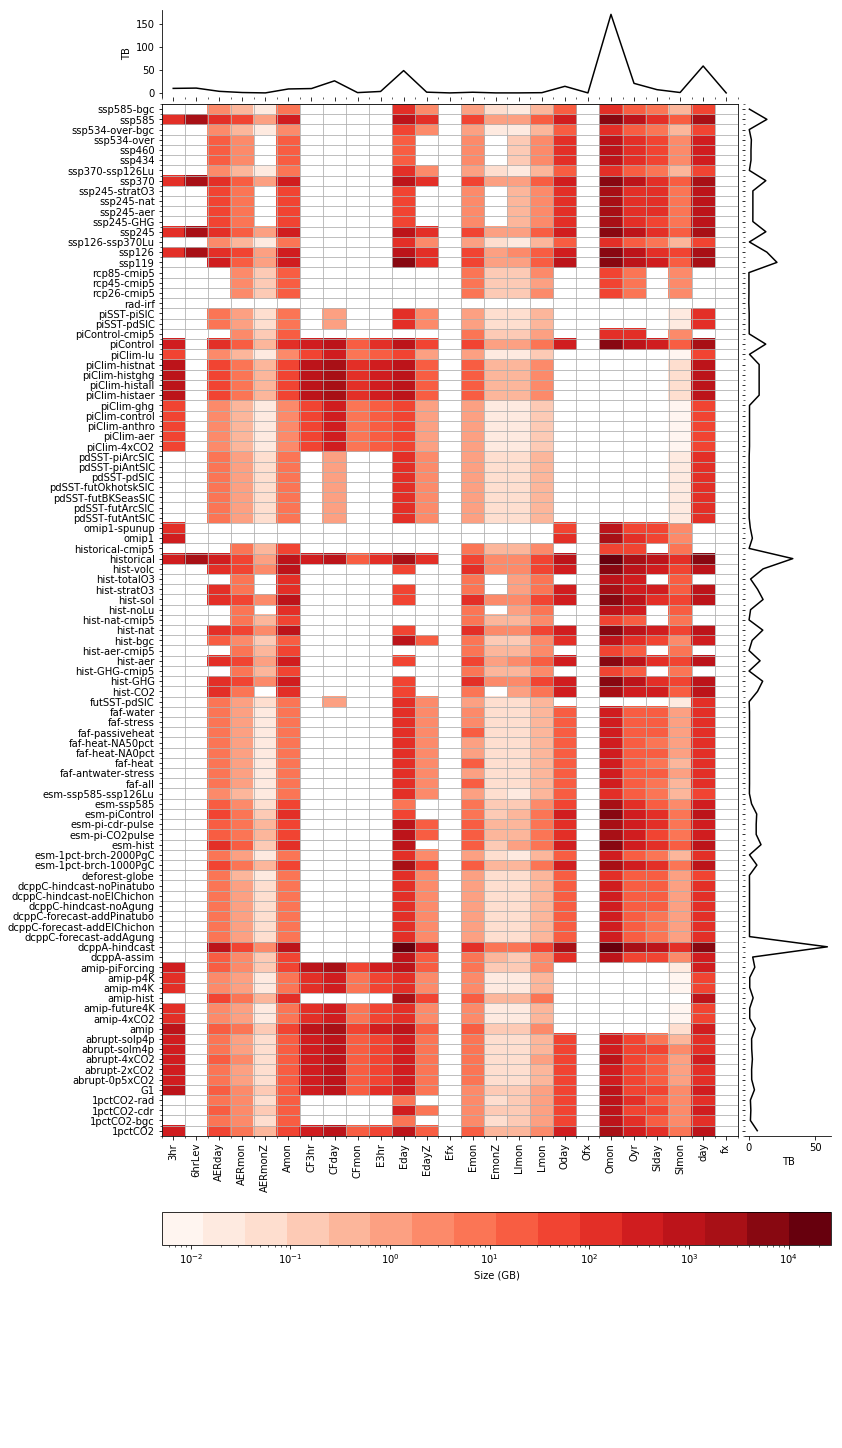

In [297]:
a = df2.groupby(['table', 'experiment'])['size'].sum().unstack().squeeze() #.pivot(index='experiment', columns='table', values='variable')
fig, ax = plt.subplots(1,1,figsize=(12,26))
nc=16
blues = plt.cm.get_cmap('Reds', 16)
blues.set_under('0.75')
#bounds=range(1,int(a.max().max()), int(a.max().max()/nc))
#norm = mpl.colors.BoundaryNorm(bounds, blues.N)
cob=ax.pcolormesh(a.fillna(0).values.T.squeeze(), cmap=blues, norm=mpl.colors.LogNorm())
ax.set_yticks(np.arange(len(a.columns))+0.5)
ax.set_yticklabels(a.columns)
ax.set_xticks(np.arange(len(a))+0.5)
ax.set_xticklabels(a.index, rotation=90)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(True, which='minor')
#ax.set_title('Number of variables finalized')
#ax.set_title('Size of published datasets')
ax.set_xlim([0,len(a)])
ax.set_ylim([0,len(a.columns)])

divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
ax_c = divider.append_axes("bottom", 1.2, pad=2.8)

# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
ax_x.plot(np.arange(len(a))+0.5, a.fillna(0).values.T.sum(axis=0)/1e3, 'k')
ax_y.plot(a.fillna(0).values.T.sum(axis=1)/1e3,np.arange(len(a.columns))+0.5, 'k')
#ax_x.set_ylim([0, len(a.columns)])
#ax_y.set_xlim([0, len(a)])
ax_y.set_xlabel('TB')
ax_x.set_ylabel('TB')
ax_x.spines['top'].set_visible(False)
ax_x.spines['right'].set_visible(False)
ax_x.spines['bottom'].set_visible(False)
ax_y.spines['right'].set_visible(False)
ax_y.spines['left'].set_visible(False)
ax_y.spines['top'].set_visible(False)

ax_c.axis('off')
plt.colorbar(cob, ax=ax_c, label='Size (GB)', orientation='horizontal')#, norm=norm, boundaries=[0]+bounds)

#fig.savefig('published-size-by-table-exp.png', bbox_inches='tight')

In [286]:
a.fillna(0).T.squeeze()

table                               3hr       6hrLev      AERday     AERmon  \
experiment                                                                    
1pctCO2                      294.710657     0.000000   46.456610   7.025493   
1pctCO2-bgc                    0.000000     0.000000    7.452279   2.002524   
1pctCO2-cdr                    0.000000     0.000000   14.831054   1.991291   
1pctCO2-rad                    0.000000     0.000000    7.469971   2.008719   
G1                           586.334304     0.000000   18.054974   3.996760   
abrupt-0p5xCO2               293.869297     0.000000    9.020856   0.994254   
abrupt-2xCO2                 292.814899     0.000000    9.043402   0.997283   
abrupt-4xCO2                 293.529224     0.000000   16.622646   2.011422   
abrupt-solm4p                293.867639     0.000000    8.991714   0.985563   
abrupt-solp4p                291.591854     0.000000    9.076482   1.000716   
amip                         582.262557     0.000000   27.374502   6.124500   
amip-4xCO2                    82.925600     0.000000    3.912534   0.874810   
amip-future4K                 82.471478     0.000000    3.929069   0.902411   
amip-hist                      0.000000     0.000000   71.562570   9.629033   
amip-m4K                      83.772742     0.000000    3.904928   0.849631   
amip-p4K                      82.468202     0.000000    3.925498   0.900271   
amip-piForcing               557.220366     0.000000   26.165136   2.883754   
dcppA-assim                    0.000000     0.000000   29.052446   3.923929   
dcppA-hindcast                 0.000000     0.000000  671.810292  76.993878   
dcppC-forecast-addAgung        0.000000     0.000000    4.948560   0.675668   
dcppC-forecast-addElChichon    0.000000     0.000000    4.948348   0.675695   
dcppC-forecast-addPinatubo     0.000000     0.000000    4.948165   0.675634   
dcppC-hindcast-noAgung         0.000000     0.000000    4.942223   0.675051   
dcppC-hindcast-noElChichon     0.000000     0.000000    4.944841   0.675226   
dcppC-hindcast-noPinatubo      0.000000     0.000000    4.945629   0.675356   
deforest-globe                 0.000000     0.000000    4.491340   0.604160   
esm-1pct-brch-1000PgC          0.000000     0.000000   59.304466   7.972185   
esm-1pct-brch-2000PgC          0.000000     0.000000    4.950260   0.665203   
esm-hist                       0.000000     0.000000   81.466351  14.256570   
esm-pi-CO2pulse                0.000000     0.000000   29.613282   7.957437   
esm-pi-cdr-pulse               0.000000     0.000000   29.611497   7.957285   
esm-piControl                  0.000000     0.000000   49.353749   9.946915   
esm-ssp585                     0.000000     0.000000   12.773920   3.447920   
esm-ssp585-ssp126Lu            0.000000     0.000000    4.257449   0.574213   
faf-all                        0.000000     0.000000    4.985170   0.671083   
faf-antwater-stress            0.000000     0.000000    4.984744   0.669994   
faf-heat                       0.000000     0.000000    4.984690   0.671022   
faf-heat-NA0pct                0.000000     0.000000    4.984455   0.670679   
faf-heat-NA50pct               0.000000     0.000000    4.984505   0.670771   
faf-passiveheat                0.000000     0.000000    4.984420   0.669999   
faf-stress                     0.000000     0.000000    4.984846   0.670192   
faf-water                      0.000000     0.000000    4.984946   0.670031   
futSST-pdSIC                   0.000000     0.000000    5.799854   0.875272   
hist-CO2                       0.000000     0.000000   84.415076  11.339462   
hist-GHG                       0.000000     0.000000   84.431537  56.703409   
hist-GHG-cmip5                 0.000000     0.000000    0.000000   5.572268   
hist-aer                       0.000000     0.000000   84.390335  34.065989   
hist-aer-cmip5                 0.000000     0.000000    0.000000   5.620824   
hist-bgc                       0.000000     0.0000

In [279]:
df2['size'].sum()/1000.

395.1462337134819

## Functionality being built

The sections above answer the question: "what have we published". The sections below try to ascertain "what should we be publishing?", and by difference, "what do we still have to publish"?

To know "what should we be publishing", we need to have the list of all variables by experiment (from variable tables), AND we need to know what experiments, and how many realizations for each experiment we have done (from the experiments table). 

In [148]:
# Load a CSV from James, giving all the variables/experiments we expect to publish.
#dfall = pd.read_csv("https://docs.google.com/uc?export=download&id=1sc-vV-UbQj3gGkEQlvlWFbg0aRURluSR")
#! https://docs.google.com/uc?export=download&id=1IBazx7TQSDHeEJhWtd_68XkhjT5G7d4I
#!ls -lrt | tail
dfall = pd.read_csv('publishable_variables_213expts_priority123_dreq01.00.29_12Mar2019.csv', header=0, names=['variable', 'table', 'experiment'])

In [259]:
experiments=list(set(dfall.experiment))
experiments.sort(reverse=True)
ne=len(experiments)
nvars=np.zeros(ne)
npvars=np.zeros(ne)

for i,exp in enumerate(experiments):
    # to publish
    dfe = dfall[dfall['experiment']==exp]
    a = list(set(dfe.variable))
    nvars[i] = len(a)
    # Actually published
    dfp = df[df['experiment']==exp]
    if len(dfp) > 0:
        b = list(set(dfp.variable))
        npvars[i] = len(b)


fig, ax = plt.subplots(1,1, figsize=(6,18))        
ax.plot(nvars, range(ne), 'k', linewidth=2, label='target')
ax.plot(npvars, range(ne),'r', label='published')
ax.set_yticks(np.arange(ne)+0.5)
ax.set_yticklabels(experiments)
ax.set_title('Number of variables to publish')
ax.axvline(x=615, color='k')
ax.set_xlabel('Number of variables')
ax.legend(loc='best', ncol=2)
fig.savefig('CMIP6-requested-vs-published-by-experiment.png', bbox_inches='tight')

NameError: name 'dfall' is not defined

In [157]:
#dfall.grouby(['experiment'])['variable'].nunique()
dfall.groupby(['experiment', 'table'])['variable'].nunique().loc['historical']

table
3hr           23
6hrLev         5
6hrPlev        3
6hrPlevPt      8
AERday         6
AERmon        31
AERmonZ        5
Amon          54
CF3hr          1
CFday         34
CFmon         52
Eday          27
EdayZ         14
Emon          38
EmonZ         11
Eyr            8
LImon          6
Lmon          34
Oclim          1
Oday           5
Ofx            7
Omon         127
Oyr           46
SIday          8
SImon         12
day           37
fx             6
Name: variable, dtype: int64

In [169]:
dfall.groupby(['table', 'experiment'])['variable'].nunique().unstack().fillna(0).sum(axis=0)

experiment
1pctCO2                       543.0
1pctCO2-4xext                 144.0
1pctCO2-bgc                   308.0
1pctCO2-cdr                   129.0
1pctCO2to4x-withism           144.0
G1                            407.0
G6solar                       407.0
G6sulfur                      407.0
G7cirrus                      407.0
abrupt-4xCO2                  534.0
amip                          485.0
amip-4xCO2                    296.0
amip-future4K                 280.0
amip-hist                     163.0
amip-p4K                      293.0
aqua-4xCO2                    259.0
aqua-control                  259.0
aqua-p4K                      259.0
dcppA-hindcast                233.0
dcppB-forecast                233.0
dcppC-amv-neg                 178.0
dcppC-amv-pos                 178.0
dcppC-atl-control             178.0
dcppC-forecast-addPinatubo    285.0
dcppC-hindcast-noPinatubo     178.0
dcppC-ipv-neg                 178.0
dcppC-ipv-pos                 178.0
dcppC-pac-control

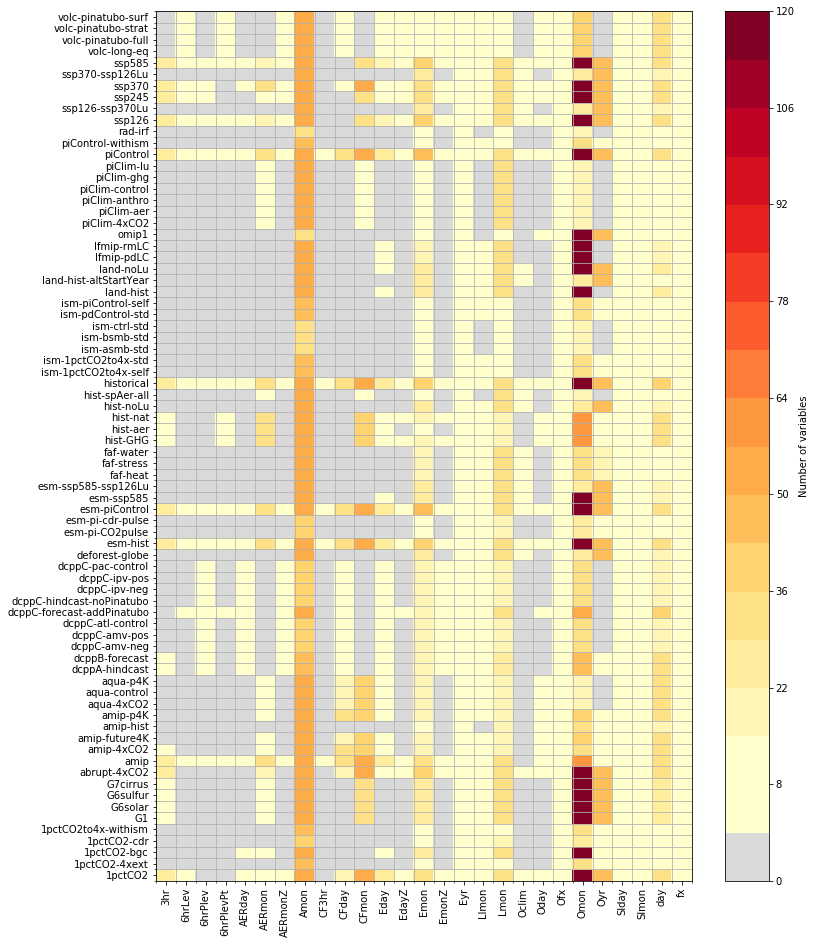

In [214]:
a = dfall.groupby(['table', 'experiment'])['variable'].nunique().unstack() #.pivot(index='experiment', columns='table', values='variable')
fig, ax = plt.subplots(1,1,figsize=(12,16))
nc=16
blues = plt.cm.get_cmap('YlOrRd', nc)
blues.set_under('0.85')
bounds=range(1,int(a.max().max()), int(a.max().max()/(nc)))
norm = mpl.colors.BoundaryNorm(bounds, blues.N)
cob=ax.pcolormesh(a.fillna(0).values.T, cmap=blues, norm=norm)
ax.set_yticks(np.arange(len(a.columns))+0.5)
ax.set_yticklabels(a.columns)
ax.set_xticks(np.arange(len(a))+0.5)
ax.set_xticklabels(a.index, rotation=90)
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(True, which='minor')
plt.colorbar(cob, label='Number of variables', norm=norm, boundaries=[0]+bounds)
#ax.set_title('Number of variables finalized')

In [255]:
df2 = pd.read_csv('canesm_cmip6_scan_12-12-2020.csv')

In [262]:
df2['size'].sum()/1000.

395.1462337134819